**QUAL O IMPACTO DA PREVISÃO DE "CHURN" PARA UMA EMPRESA?**

A previsão do "Churn" (Capacidade de uma empresa de antecipar quais clientes estão prestes a abandonar seus serviços) é de vital importância para uma instituição, visto que, mediante as características desses, clientes, é possível propor melhorias a fim de elevar a satisfação dos mesmos e evitar esse abandono. Além disso, há um impacto significativo para a saúde financeira da empresa, dado que uma perda maciça da clientela pode ocasionar grandes perdas de receita. Portanto, é de grande valia a realização desse estudo para assegurar o bom funcionamento de uma dada instituição.

**INSTALANDO E ATUALIZANDO ALGUMAS BIBLIOTECAS A SEREM UTILIZADAS**

In [ ]:
pip install scikeras

In [ ]:
pip uninstall scikit-learn --yes

In [ ]:
pip uninstall imblearn --yes

In [ ]:
pip install scikit-learn==1.2.2

In [ ]:
pip install imblearn

In [ ]:
pip install boruta

In [ ]:
pip install shap

**IMPORTANDO BIBLIOTECAS**

In [9]:
import shap
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pandas as pd
import tensorflow as tf
import statistics as st
import matplotlib.pyplot as plt
from scipy.stats import zscore
from boruta import BorutaPy
from keras.layers import Input, Dense
from keras.models import Sequential
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, ConfusionMatrixDisplay, classification_report, accuracy_score

**MECANISMO DE CONSTRUÇÃO DE HISTOGRAMAS**

O mecanismo abaixo será utilizado tanto no tópico de imputação simples quanto no de normalização.

In [17]:
def hist_mec (dataset, h_list):

  for h_i in h_list:

      plt.figure(figsize=(9, 4))

      # Histograma

      plt.subplot(1, 2, 1)
      sns.histplot(dataset[h_i], kde=True, shrink=1)
      plt.title(f'Histograma de {h_i}')

      # Gráfico Q-Q

      plt.subplot(1, 2, 2)
      stats.probplot(dataset[h_i], dist="norm", plot=plt)
      plt.title(f'Gráfico Q-Q de {h_i}')

      plt.tight_layout()
      plt.show()

**IMPORTANDO BASE DE DADOS**

In [10]:
data = pd.read_excel('e_commerce_dataset.xlsx')
print(data.head())

   CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female             3.0                         3   
1                  UPI    Male             3.0                         4   
2           Debit Card    Male             2.0                         4   
3           Debit Card    Male             2.0                         4   
4                   CC    Male             NaN                         3   

     PreferedOrderCat  SatisfactionScore MaritalStatus  Number

In [11]:
print(data.shape)

(5630, 20)


Para averiguar os valores faltantes na base de dados, tem-se que:

In [12]:
missing_values = data.isnull().sum()
print(missing_values)

CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64


Ao se trabalhar com dados faltantes em análises de dados, tem-se as seguintes hipóteses:

*   Caso a quantidade de dados faltantes sejam inferiores à 5%, é permitida a remoção das linhas que contém os dados incompletos;
*   Caso a quantidade de dados faltantes estejam entre 5% e 10%, recomenda-se a aplicação do processo de imputação simples, o qual visa completar as lacunas ausentes com a média, mediana ou moda da coluna pertencente ao valor inexistente.


Desse modo, é importante saber quantos dados correspondem à 5% e 10% dentro do dataframe a ser trabalhado. Logo:


In [13]:
pc = [0.05, 0.1]

for pcent in pc:

  quantity_pc = pcent*(data.shape[0])
  print (f'{(pcent*100):.0f}% de valores nulos: {quantity_pc:.0f} dados.')

5% de valores nulos: 282 dados.
10% de valores nulos: 563 dados.


Se todas as colunas com ítens faltantes possuíssem, no máximo, 282 valores nulos, seria viável a exclusão dessas linhas. Entretanto, observou-se que a coluna "DaySinceLastOrder" possui 307 valores faltante, tornando mais coerente a aplicação do método de imputação simples.

**MÉTODO DE IMPUTAÇÃO SIMPLES**

Nesse tópico, será realizado o método de imputação simples para a correção dos dados faltantes a partir da inserção da média ou mediana das colunas onde tais lacunas estão presentes. Logo, antes da imputação, tem-se que:

In [14]:
print(data)

      CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  \
0          50001      1     4.0         Mobile Phone         3   
1          50002      1     NaN                Phone         1   
2          50003      1     NaN                Phone         1   
3          50004      1     0.0                Phone         3   
4          50005      1     0.0                Phone         1   
...          ...    ...     ...                  ...       ...   
5625       55626      0    10.0             Computer         1   
5626       55627      0    13.0         Mobile Phone         1   
5627       55628      0     1.0         Mobile Phone         1   
5628       55629      0    23.0             Computer         3   
5629       55630      0     8.0         Mobile Phone         1   

      WarehouseToHome PreferredPaymentMode  Gender  HourSpendOnApp  \
0                 6.0           Debit Card  Female             3.0   
1                 8.0                  UPI    Male             3.0 

As features a serem imputadas, baseando no missing_values, são:

In [15]:
imputer_list = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder']

Para se avaliar a utilização da média ou da mediana, elaborou-se um histograma de frequência e um gráfico Q-Q para as features passíveis de imputação.

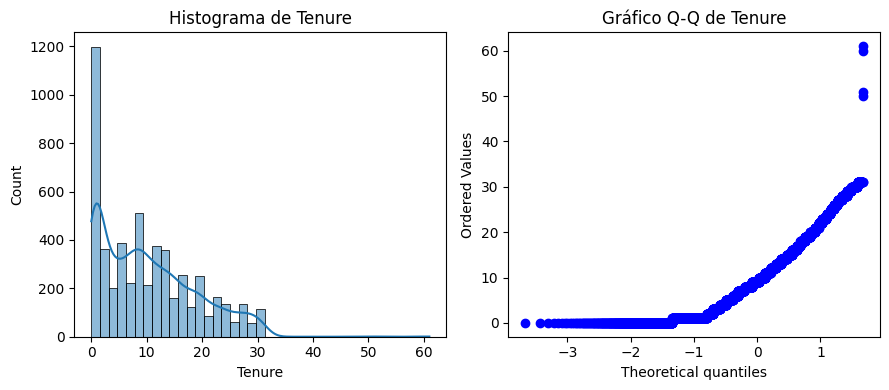

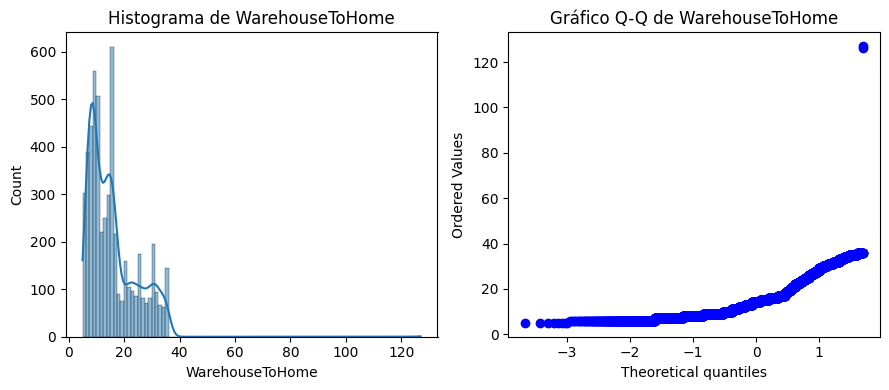

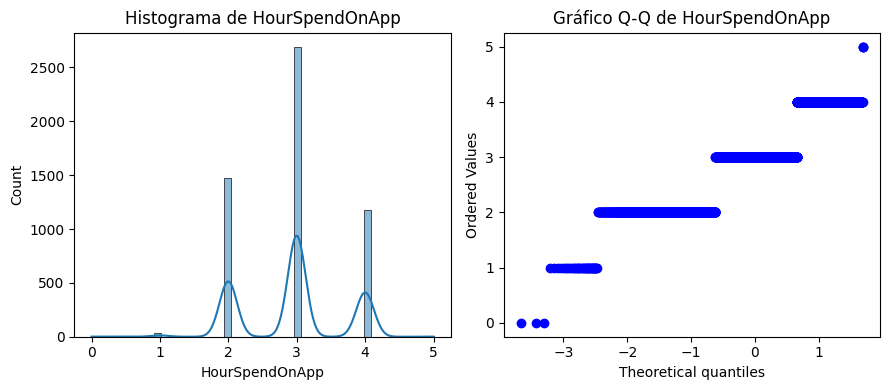

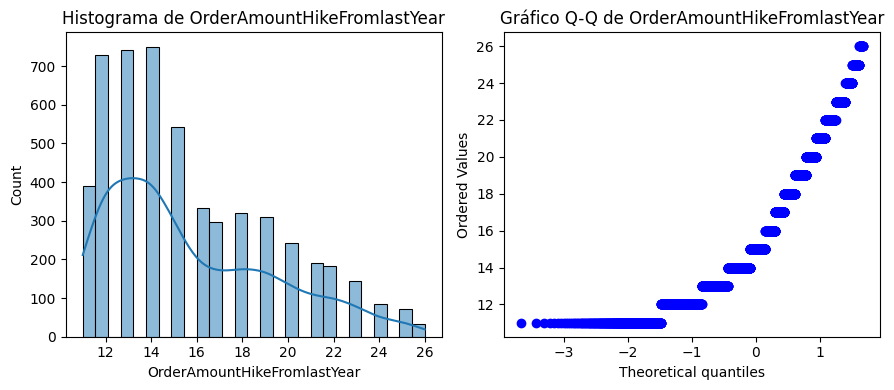

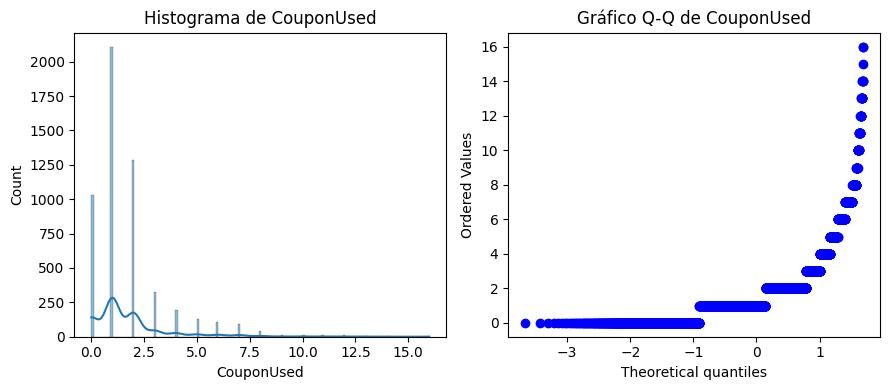

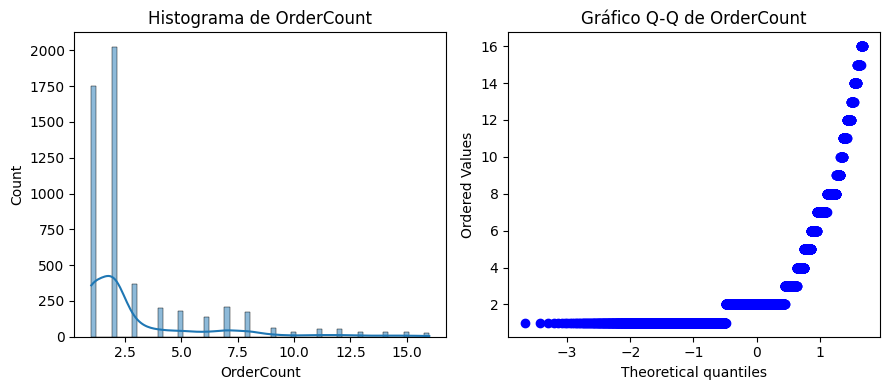

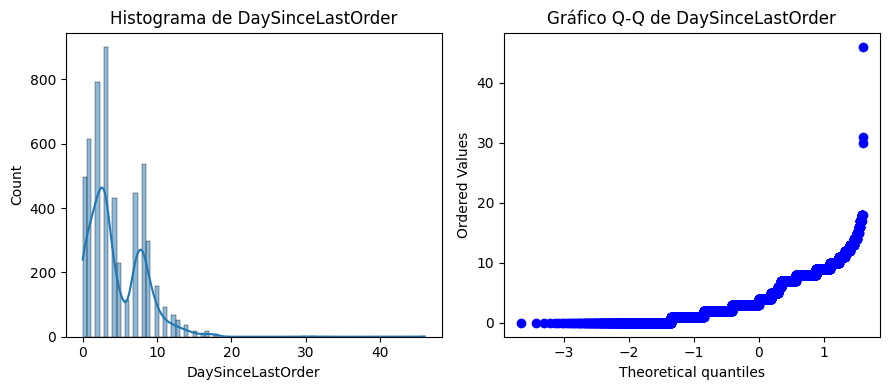

In [18]:
hist_mec (data, imputer_list)

Tendo em vista que nenhuma das features acima apresentou distribuição normal, é viável o uso da mediana no método de imputação simples, visto que ela é mais representativa em distribuições assimétricas. Aplicando-se o método de imputação simples, tem-se que:

In [19]:
imputer = SimpleImputer(strategy='median')

imputer_list = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder']

for var in imputer_list:

  variable = data[var].values.reshape(-1, 1)
  variable_imputed = imputer.fit_transform(variable)
  data[var] = variable_imputed

Após a imputação, tem-se os seguintes resultados:

In [20]:
print (data)

      CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  \
0          50001      1     4.0         Mobile Phone         3   
1          50002      1     9.0                Phone         1   
2          50003      1     9.0                Phone         1   
3          50004      1     0.0                Phone         3   
4          50005      1     0.0                Phone         1   
...          ...    ...     ...                  ...       ...   
5625       55626      0    10.0             Computer         1   
5626       55627      0    13.0         Mobile Phone         1   
5627       55628      0     1.0         Mobile Phone         1   
5628       55629      0    23.0             Computer         3   
5629       55630      0     8.0         Mobile Phone         1   

      WarehouseToHome PreferredPaymentMode  Gender  HourSpendOnApp  \
0                 6.0           Debit Card  Female             3.0   
1                 8.0                  UPI    Male             3.0 

Para confirmar a inexistência dos dados faltantes após a imputação:

In [21]:
missing_values_post_treatment = data.isnull().sum()
print(missing_values_post_treatment)

CustomerID                     0
Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
PreferedOrderCat               0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
dtype: int64


Por fim, para se avaliar a presença de "IDs" duplicadas (para evitar informações duplicadas), tem-se que:

In [22]:
print(data['CustomerID'].duplicated().sum())

0


Logo, não há linhas duplicadas no conjunto de dados.

**ELIMINANDO A COLUNA "CustomerID", VISTO QUE ELA NÃO POSSUI IMPACTO NA ETAPA DE PREDIÇÃO (SERVE APENAS PARA IDENTIFICAÇÃO)**

In [23]:
data = data.drop("CustomerID", axis = 1)
data

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,1,9.0,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,1,9.0,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,1,0.0,Phone,1,12.0,CC,Male,3.0,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,0,10.0,Computer,1,30.0,Credit Card,Male,3.0,2,Laptop & Accessory,1,Married,6,0,18.0,1.0,2.0,4.0,150.71
5626,0,13.0,Mobile Phone,1,13.0,Credit Card,Male,3.0,5,Fashion,5,Married,6,0,16.0,1.0,2.0,3.0,224.91
5627,0,1.0,Mobile Phone,1,11.0,Debit Card,Male,3.0,2,Laptop & Accessory,4,Married,3,1,21.0,1.0,2.0,4.0,186.42
5628,0,23.0,Computer,3,9.0,Credit Card,Male,4.0,5,Laptop & Accessory,4,Married,4,0,15.0,2.0,2.0,9.0,178.90


**DIVIDINDO AS VARIÁVEIS DE ENTRADA E SAÍDA**

In [24]:
y = data.iloc[:,0]
x = data.iloc[:,1:]

**TRANSFORMANDO DADOS CATEGÓRICOS EM NUMÉRICOS - LABEL ENCODER**

Tendo em vista que o algoritmo BorutaPy utilizado mais adiante será baseado em árvores de decisões, é mais viável utilizar o encoder categórico Label Encoder para evitar a esparsidade do banco de dados, o que prejudicaria a predição do modelo. Logo:

In [25]:
columns_to_encode = ["PreferredLoginDevice", "PreferredPaymentMode", "Gender", "PreferedOrderCat", "MaritalStatus"]

In [26]:
encoder = LabelEncoder()

In [27]:
x_le = x

In [28]:
for column in columns_to_encode:

    x_le[column] = encoder.fit_transform(x_le[column])

In [29]:
x_le

,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,4.0,1,3,6.0,4,0,3.0,3,2,2,2,9,1,11.0,1.0,1.0,5.0,159.93
1,9.0,2,1,8.0,6,1,3.0,4,3,3,2,7,1,15.0,0.0,1.0,0.0,120.90
2,9.0,2,1,30.0,4,1,2.0,4,3,3,2,6,1,14.0,0.0,1.0,3.0,120.28
3,0.0,2,3,15.0,4,1,2.0,4,2,5,2,8,0,23.0,0.0,1.0,3.0,134.07
4,0.0,2,1,12.0,0,1,3.0,3,3,5,2,3,0,11.0,1.0,1.0,3.0,129.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,10.0,0,1,30.0,3,1,3.0,2,2,1,1,6,0,18.0,1.0,2.0,4.0,150.71
5626,13.0,1,1,13.0,3,1,3.0,5,0,5,1,6,0,16.0,1.0,2.0,3.0,224.91
5627,1.0,1,1,11.0,4,1,3.0,2,2,4,1,3,1,21.0,1.0,2.0,4.0,186.42
5628,23.0,0,3,9.0,3,1,4.0,5,2,4,1,4,0,15.0,2.0,2.0,9.0,178.90


**SELEÇÃO DE FEATURES**



*   BorutaPy



BorutaPy é uma implementação em Python do algoritmo Boruta, usado para seleção de variáveis em modelos de aprendizado de máquina. Ele serve para identificar quais características de um conjunto de dados são mais relevantes para a predição, eliminando aquelas que são irrelevantes ou redundantes. O BorutaPy realiza múltiplas iterações de treinamento de um modelo com árvores de decisão, avaliando a importância de cada característica em comparação com variáveis artificiais. É útil para melhorar a eficiência e a interpretabilidade dos modelos. Aplicando o BorutaPy, tem-se que:

In [30]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [31]:
boruta_selector = BorutaPy(estimator=rf, n_estimators='auto', verbose=2, random_state=42)

In [32]:
x_le1 = x_le.values

Para evitar problemas de compatibilidade para os diversos tipos de variáveis no BorutaPy:

In [33]:
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

In [34]:
boruta_selector.fit(x_le1, y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	11
Itera

BorutaPy(estimator=RandomForestClassifier(n_estimators=37,
                                          random_state=RandomState(MT19937) at 0x7F7F16D45040),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F7F16D45040, verbose=2)

In [35]:
selected_features = x_le.columns[boruta_selector.support_]

In [36]:
selected_features_df = pd.DataFrame(selected_features, columns=["Características selecionadas"])
print(selected_features_df)

  Características selecionadas
0                       Tenure
1              WarehouseToHome
2              NumberOfAddress
3                     Complain
4            DaySinceLastOrder
5               CashbackAmount


Observa-se que o BorutaPy indicou os 6 features elencados acima. Para reforçar que a escolha desses parâmetros é representativa para o modelo, será implementada mais duas análises de features: a mutual information e a análise de correlação.



*   Mutual information


O gráfico de mutual information é crucial para a escolha de features porque quantifica a dependência mútua entre cada feature e o target. Aplicando o gráfico da mutual information, tem-se que:

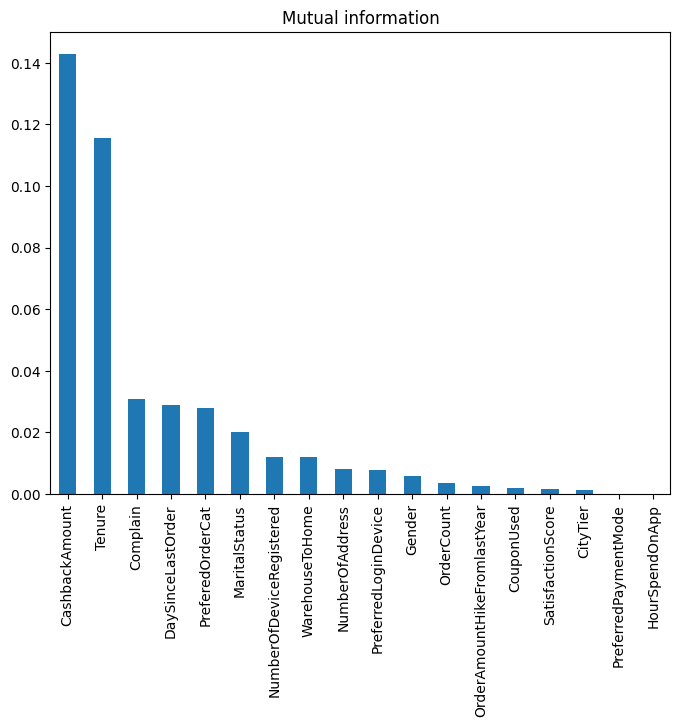

In [37]:
mutual_info = mutual_info_classif(x_le, y)

mutual_info_series = pd.Series(mutual_info, index=x_le.columns)
mutual_info_series = mutual_info_series.sort_values(ascending=False)

plt.figure(figsize=(8,6))
mutual_info_series.plot(kind='bar')
plt.title('Mutual information')
plt.show()

Observou-se que, das 6 features sugeridas pelo BorutaPy, apenas a "NumberOfAddress" e a "WarehouseToHome" não se mostraram muito significativas. Dando continuidade às análises, será avaliada a análise de correlação.



*   Análise de correlação



A análise de correlação utilizando heatmaps é crucial na seleção de features porque ajuda a identificar relações fortes entre variáveis, facilitando a detecção de redundâncias e colinearidades. Aplicando-se a análise de correlação, tem-se que:

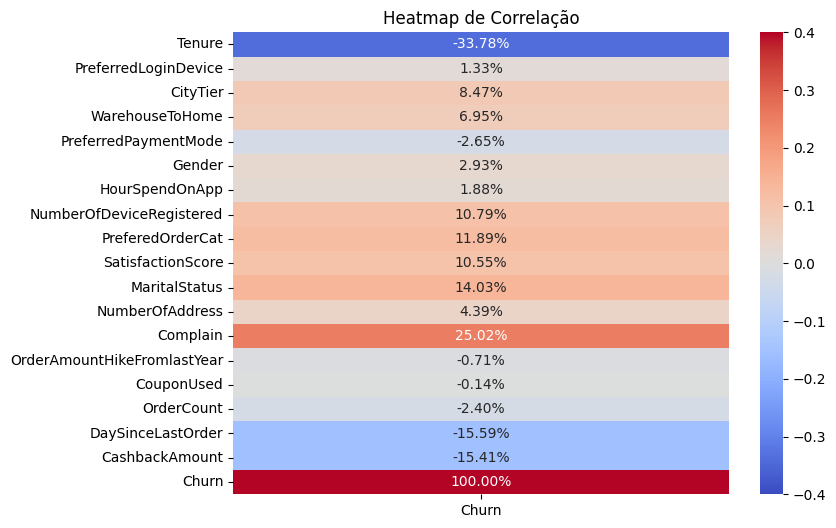

In [38]:
df_combined = pd.concat([x_le, y], axis=1)

correlation_matrix = df_combined.corr()
correlation_matrix = correlation_matrix[['Churn']]

plt.figure(figsize=(8, 6))

def fmt_percent_bold(val):
    return f'{val * 100:.2f}%'

sns.heatmap(correlation_matrix, annot=correlation_matrix.applymap(fmt_percent_bold), fmt='', cmap='coolwarm', vmin=-0.4, vmax=0.4)
plt.title('Heatmap de Correlação')
plt.show()

Nesta situação, também observou-se que tanto o "NumberOfAddress" quanto o "WarehouseToHome" não demonstraram satisfatórias correlações com a variável target.

*   Novo dataframe de X com as melhores features escolhidas anteriormente:



Tendo em vista as análises anteriores, tem-se que as features escolhidas para o modelo preditivo serão: "Tenure", "CashbackAmount", "DaySinceLastOrder" e "Complain".

In [39]:
x_best = x[['Tenure', 'CashbackAmount', 'DaySinceLastOrder','Complain']]

In [40]:
x_best

,Tenure,CashbackAmount,DaySinceLastOrder,Complain
0,4.0,159.93,5.0,1
1,9.0,120.90,0.0,1
2,9.0,120.28,3.0,1
3,0.0,134.07,3.0,0
4,0.0,129.60,3.0,0
...,...,...,...,...
5625,10.0,150.71,4.0,0
5626,13.0,224.91,3.0,0
5627,1.0,186.42,4.0,1
5628,23.0,178.90,9.0,0


Observa-se que nenhuma coluna de dados categóricos foi selecionada, o que culmina na não necessidade da aplicação do "OneHotEncoder" para a categorização dos dados a serem utilizados nas posteriores predições.

**DIVIDINDO DADOS DE TREINO E TESTE**

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x_best,y,test_size = 0.3, stratify = y, random_state = 42)

In [42]:
x_train

,Tenure,CashbackAmount,DaySinceLastOrder,Complain
1186,9.0,115.14,0.0,0
3145,7.0,286.84,6.0,0
608,0.0,154.72,3.0,0
5202,18.0,156.62,4.0,0
4133,16.0,313.80,15.0,0
...,...,...,...,...
1916,0.0,143.64,0.0,0
5038,16.0,187.72,4.0,0
1384,6.0,153.76,3.0,0
4026,29.0,151.62,5.0,0


In [43]:
y_train

1186    0
3145    0
608     0
5202    0
4133    0
       ..
1916    0
5038    0
1384    0
4026    0
2761    0
Name: Churn, Length: 3941, dtype: int64

**VERIFICANDO O DESBALANCEAMENTO DOS DADOS E APLICANDO OS MÉTODOS DE CORREÇÃO**

Para avaliarmos a proporção entre dados de ambas as classes avaliadas, tem-se que:

In [44]:
y_train.value_counts()

Churn
0    3277
1     664
Name: count, dtype: int64

Observa-se um evidente desbalanceamento entre essas classes. Para corrigir isso, avaliaremos as técnicas SMOTE e NEAR MISS.

*   SMOTE



In [45]:
smt = SMOTE()
x_train_smt, y_train_smt = smt.fit_resample(x_train, y_train)

In [46]:
np.bincount(y_train_smt)

array([3277, 3277])

*   NEAR MISS



In [47]:
nr = NearMiss()
x_train_nm, y_train_nm = nr.fit_resample(x_train, y_train)

In [48]:
np.bincount(y_train_nm)

array([664, 664])

*   QUAL O MELHOR BALANCEAMENTO?



O melhor método de balanceamento será identificado mais adiante, após as predições com os dados provenientes das duas técnicas citadas anteriormente.

**ESCALONAMENTO DOS DADOS**

Para realizar o escalonamento dos dados, é importante, inicialmente, averiguar a distribuição destes em cada feature. Ademais, é crucial a verificação da presença ou não de outliers. Sendo assim:



*   SMOTE



In [49]:
param_norm = ['Tenure', 'CashbackAmount', 'DaySinceLastOrder','Complain']

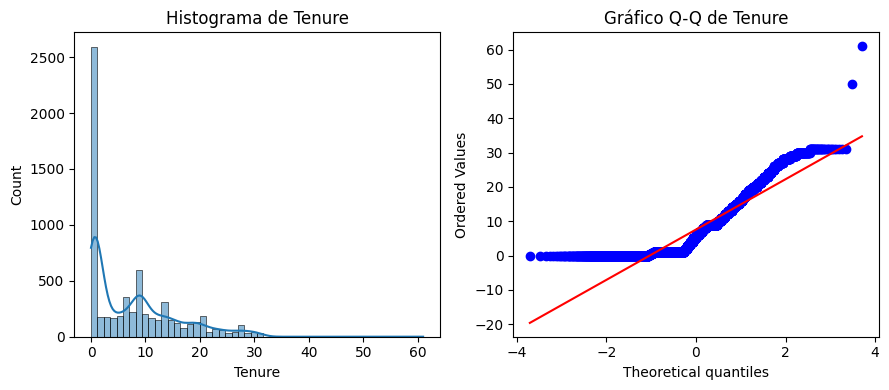

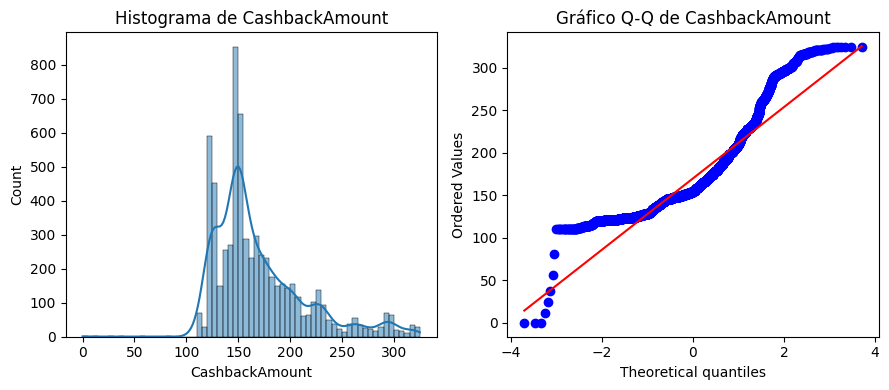

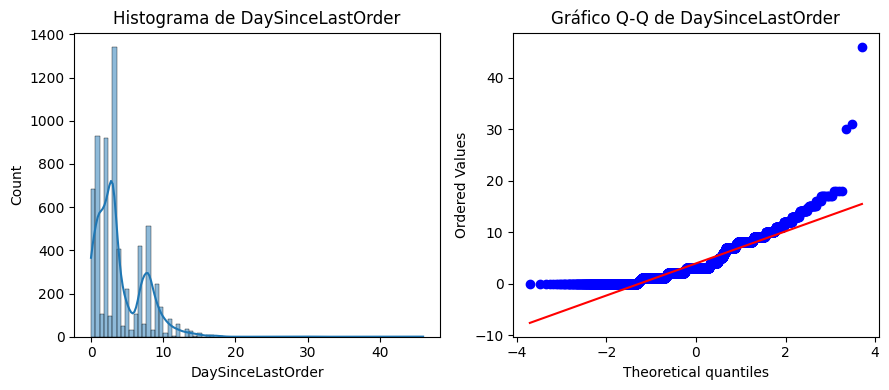

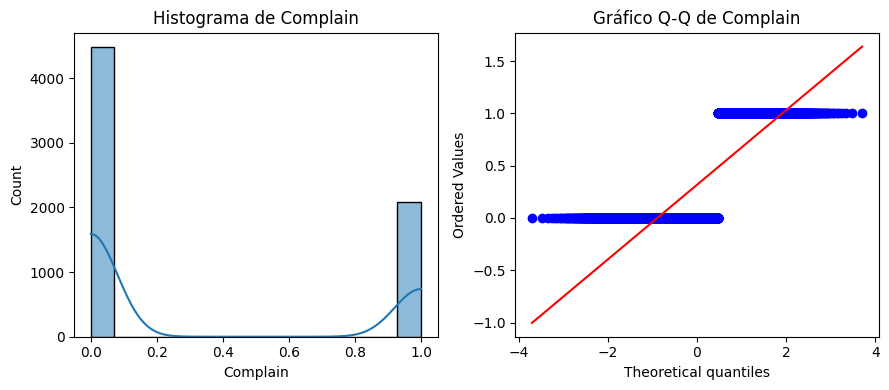

In [50]:
hist_mec (x_train_smt, param_norm)

In [51]:
df_x_train_smt = pd.DataFrame(x_train_smt)

z_scores = df_x_train_smt.apply(zscore)

outliers = (z_scores > 3) | (z_scores < -3)

outliers_x_train_smt = df_x_train_smt[outliers.any(axis=1)]

print(f"Z-Scores: {z_scores}")

print(f"\nOutliers encontrados: {outliers_x_train_smt}")

Z-Scores:         Tenure  CashbackAmount  DaySinceLastOrder  Complain
0     0.181776       -1.224290          -1.173555 -0.681362
1    -0.070231        2.602828           0.627223 -0.681362
2    -0.952256       -0.342069          -0.273166 -0.681362
3     1.315808       -0.299719           0.026964 -0.681362
4     1.063801        3.203755           3.328391 -0.681362
...        ...             ...                ...       ...
6549 -0.166938        0.206243           0.096746 -0.681362
6550 -0.826252       -0.647003          -0.873425  1.467649
6551 -0.952256       -0.938590          -0.827483  1.467649
6552 -0.826252       -0.422757          -0.273166 -0.681362
6553 -0.826252        1.222866          -0.273166 -0.681362

[6554 rows x 4 columns]

Outliers encontrados:          Tenure  CashbackAmount  DaySinceLastOrder  Complain
4     16.000000      313.800000          15.000000         0
24    21.000000      262.700000          14.000000         1
86     0.000000      206.090000        

In [52]:
percent_outliers = (outliers_x_train_smt.shape[0]) / (z_scores.shape[0])*100

print (f"Percentual de outliers: {percent_outliers:.2f}%")

Percentual de outliers: 2.35%


Diante das exposições gráficas vistas acima, observa-se que nenhuma feature tem uma distribuição normal dos dados. Além disso, foram constatados pouco mais de 2% de outliers, quantidade essa insignificante. Sendo assim, é viável a implementação do "MinMaxScaler" para o escalonamento mediante o balanceamento Smote.

In [53]:
sc_smt = MinMaxScaler()
x_train_smt = sc_smt.fit_transform(x_train_smt)
x_test_smt = sc_smt.transform(x_test)



*   NEAR MISS



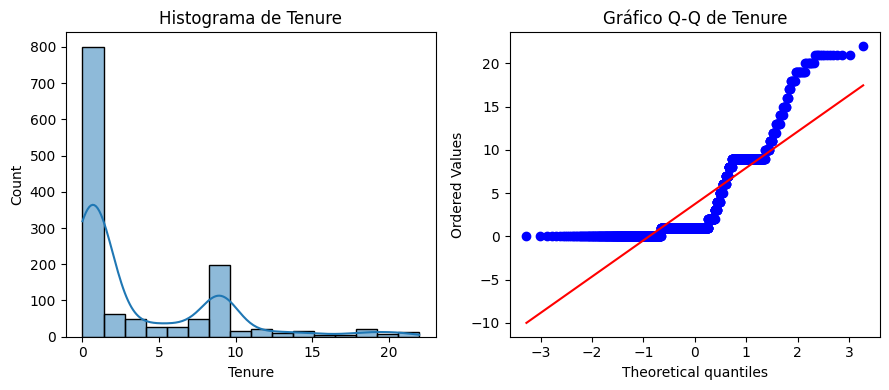

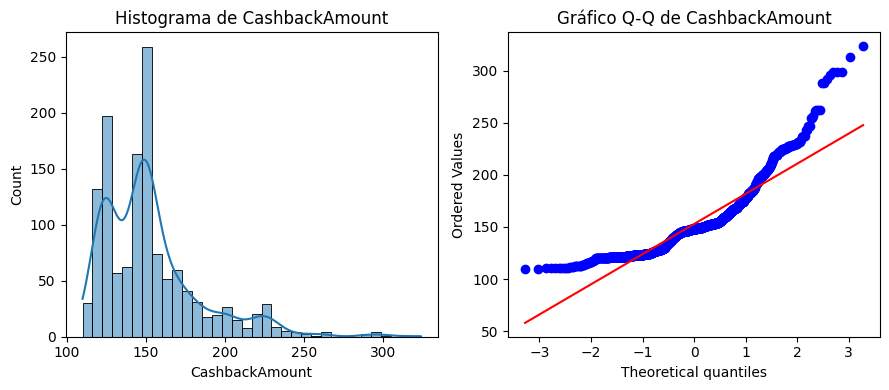

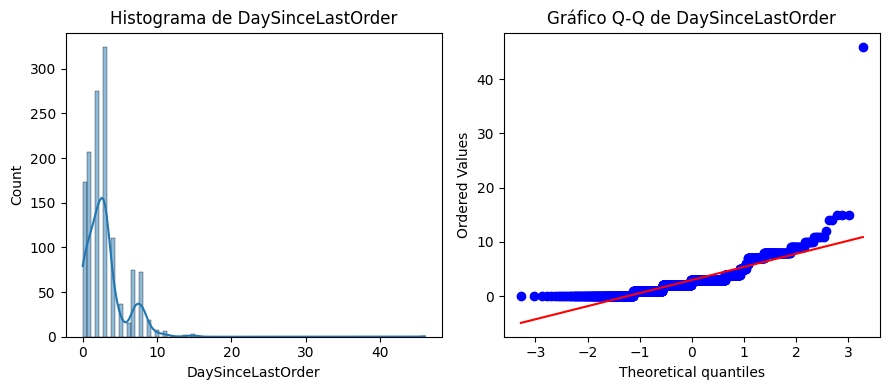

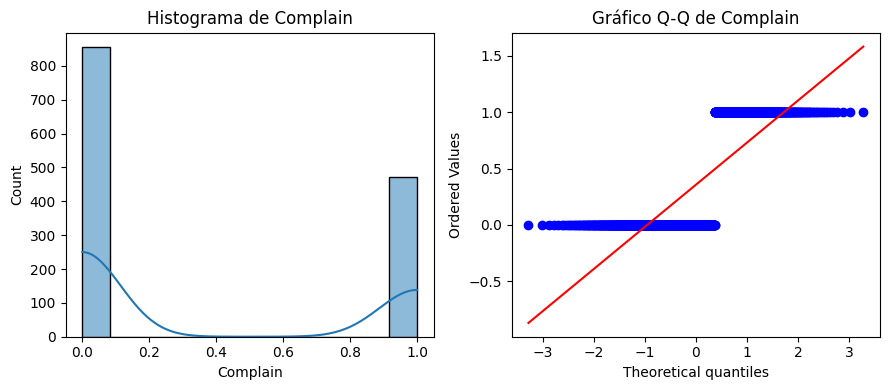

In [54]:
hist_mec (x_train_nm, param_norm)

In [55]:
df_x_train_nm = pd.DataFrame(x_train_nm)

z_scores = df_x_train_nm.apply(zscore)

outliers = (z_scores > 3) | (z_scores < -3)

outliers_x_train_nm = df_x_train_nm[outliers.any(axis=1)]

print(f"Z-Scores: {z_scores}")

print(f"\nOutliers encontrados: {outliers_x_train_nm}")

Z-Scores:         Tenure  CashbackAmount  DaySinceLastOrder  Complain
0    -0.561238       -0.055072          -0.000820 -0.743785
1    -0.561238       -0.055072          -0.000820 -0.743785
2    -0.767299       -0.857963          -0.363987 -0.743785
3    -0.767299       -0.857963          -0.363987 -0.743785
4    -0.561238       -0.028095          -0.727154 -0.743785
...        ...             ...                ...       ...
1323 -0.561238        0.033567          -0.000820  1.344474
1324 -0.767299       -0.823921          -1.090320 -0.743785
1325 -0.767299       -0.934077          -0.363987  1.344474
1326 -0.561238       -0.058284          -0.727154  1.344474
1327  1.087252       -1.043270          -1.090320 -0.743785

[1328 rows x 4 columns]

Outliers encontrados:       Tenure  CashbackAmount  DaySinceLastOrder  Complain
442     19.0          150.21                2.0         1
474     20.0          149.78                0.0         0
525     22.0          150.59                1.0 

In [56]:
percent_outliers = (outliers_x_train_nm.shape[0]) / (z_scores.shape[0])*100

print (f"Percentual de outliers: {percent_outliers:.2f}%")

Percentual de outliers: 3.92%


Diante dos gráficos acima, observa-se que nenhuma features tem uma distribuição normal dos dados. Ademais, também foram constatados poucos outliers. Desse modo, também é interessante o uso do "MinMaxScaler" no escalonamento para o caso do balanceamento Near Miss.

In [57]:
sc_nm = MinMaxScaler()
x_train_nm = sc_nm.fit_transform(x_train_nm)
x_test_nm = sc_nm.transform(x_test)

**FUNÇÕES DOS MODELOS PREDITIVOS**

Utilizou-se o "Recall" como métrica principal de avaliação das predições pelo fato deste indicador ter uma maior efetividade no estudo dos falsos negativos. A aparição de falsos negativos é bastante prejudicial nesta ocasião, dado que o erro na previsão da não saída de clientes pode ocasionar prejuízos financeiros significativos para a instituição. **A saída inesperada e expressiva de clientes coloca em risco a saúde financeira de uma empresa.**



*   Para escolha dos hiperparâmetros



In [61]:
def train_test_hp(criterion, min_samp_split, list_scores_rf, list_ReturnRecall_rf, list_ReturnAccuracy_rf, x_train, y_train, x_test, y_test):

    rf = RandomForestClassifier(n_estimators=100, criterion = criterion, min_samples_split = min_samp_split,  random_state=42)
    rf.fit(x_train, y_train)

    y_pred = rf.predict(x_test)

    score_recall = recall_score(y_test, y_pred) * 100
    score_accuracy = accuracy_score(y_test, y_pred) * 100

    score_model = cross_val_score(rf, x_test, y_test, cv=5, scoring='accuracy')

    list_scores_rf.append(score_model)
    list_ReturnRecall_rf.append(score_recall)
    list_ReturnAccuracy_rf.append(score_accuracy)

    print(f"Recall e Acurácia (RF) com a validação (%): {score_recall} e {score_accuracy}. Scores do modelo {criterion} (MSP = {min_samp_split}): {score_model}")



*   Hiperparâmetros e Thresholds a serem avaliados



In [59]:
criterion = ['gini', 'entropy', 'log_loss']

min_samples_split = [2,3,4,5,6]

thresholds = [0.4, 0.5, 0.6]



*   Para treino e teste



In [62]:
def train_test(criterion, min_samp_split, threshold, x_train, y_train, x_test, y_test):

    rf = RandomForestClassifier(n_estimators=100, criterion = criterion, min_samples_split = min_samp_split,  random_state=42)
    rf.fit(x_train, y_train)
    y_pred = rf.predict_proba(x_test)[:, 1]

    y_pred = (y_pred > threshold)

    pred_array = y_pred.reshape(len(y_pred), 1)
    test_array = y_test.values.reshape(len(y_test), 1)

    score_recall = recall_score(y_test, y_pred) * 100
    score_accuracy = accuracy_score(y_test, y_pred) * 100

    score_model = cross_val_score(rf, x_test, y_test, cv=5, scoring='accuracy')
    score_model = st.mean(score_model)

    cm = confusion_matrix(test_array, pred_array)

    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Not churn", "Churn"])

    cm_display.plot()
    plt.show()

    print("Recall da validação (%): ", ((recall_score(y_test, y_pred)*100)))
    print("Acurácia da validação (%): ", ((accuracy_score(y_test, y_pred)*100)))
    print("SCORE do modelo (%): ", (score_model*100))

**IMPLEMENTANDO O APRENDIZADO DE MÁQUINA (BALANCEAMENTO SMOTE)**


*   Seleção dos hiperparâmetros do modelo preditivo:



In [63]:
list_ReturnRecall_smt = []
list_ReturnAccuracy_smt = []
list_scoresm_smt = []

list_order_criterion = []
list_order_min_samples_split = []

for i in criterion:

  for j in min_samples_split:

    list_order_criterion.append(i)
    list_order_min_samples_split.append(j)

    train_test_hp(i, j, list_scoresm_smt, list_ReturnRecall_smt, list_ReturnAccuracy_smt, x_train_smt, y_train_smt, x_test_smt, y_test)

Recall e Acurácia (RF) com a validação (%): 83.09859154929578 e 94.90822972172883. Scores do modelo gini (MSP = 2): [0.87573964 0.89349112 0.90532544 0.89053254 0.89910979]
Recall e Acurácia (RF) com a validação (%): 83.09859154929578 e 94.31616341030195. Scores do modelo gini (MSP = 3): [0.86982249 0.89053254 0.90828402 0.88461538 0.90207715]
Recall e Acurácia (RF) com a validação (%): 79.5774647887324 e 92.95441089402013. Scores do modelo gini (MSP = 4): [0.86982249 0.88461538 0.8964497  0.87869822 0.90207715]
Recall e Acurácia (RF) com a validação (%): 77.11267605633803 e 92.30313795145057. Scores do modelo gini (MSP = 5): [0.87278107 0.87869822 0.8964497  0.86686391 0.89910979]
Recall e Acurácia (RF) com a validação (%): 75.0 e 91.41503848431024. Scores do modelo gini (MSP = 6): [0.86982249 0.88461538 0.90236686 0.85502959 0.90504451]
Recall e Acurácia (RF) com a validação (%): 83.09859154929578 e 94.90822972172883. Scores do modelo entropy (MSP = 2): [0.87278107 0.89053254 0.90236



*   Recall, Acurácia e Score da validação cruzada do modelo para cada hiperparâmetro estudado:



In [64]:
list_scoresm_average_smt = []
list_scoresm_std_smt = []

for w in list_scoresm_smt:

  average = st.mean(w)
  std = st.stdev(w)

  list_scoresm_average_smt.append(average*100)
  list_scoresm_std_smt.append(std*100)

data_df = {'MSP': list_order_min_samples_split, 'Recall': list_ReturnRecall_smt, 'Accuracy': list_ReturnAccuracy_smt, 'MEAN SCORE': list_scoresm_average_smt, 'STD SCORE': list_scoresm_std_smt}

df_criterions_smt = pd.DataFrame (data_df, index = list_order_criterion, columns = ['MSP', 'Recall', 'Accuracy', 'MEAN SCORE', 'STD SCORE']).sort_values('Recall', ascending=False)
df_criterions_smt

,MSP,Recall,Accuracy,MEAN SCORE,STD SCORE
gini,2,83.098592,94.908230,89.283971,1.110593
gini,3,83.098592,94.316163,89.106632,1.509046
entropy,2,83.098592,94.908230,89.343318,1.250154
log_loss,2,83.098592,94.908230,89.343318,1.250154
entropy,3,82.746479,94.493783,89.402665,1.419545
log_loss,3,82.746479,94.493783,89.402665,1.419545
entropy,4,79.929577,93.309651,88.929117,1.186626
log_loss,4,79.929577,93.309651,88.929117,1.186626
gini,4,79.577465,92.954411,88.633259,1.307730
entropy,5,77.464789,92.243931,88.455744,1.362494


Observa-se, na tabela acima, que o critério "gini" com valor de min_samples_split igual a 2 obteve o melhor indicador de recall, acuracidade e de desvio-padrão, além de um representativo score de validação de modelo. Sendo assim, este será utilizado para o posterior treino e teste do modelo sob diferentes thresholds no balanceamento Smote.



*   Treino e Predição:



Para a predição, foram adotados 3 valores de threshold e avaliado qual o melhor desempenho dentre eles.

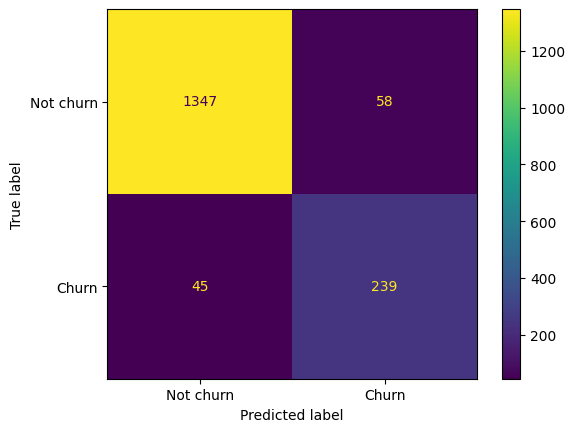

Recall da validação (%):  84.15492957746478
Acurácia da validação (%):  93.90171699230314
SCORE do modelo (%):  89.28397099362633


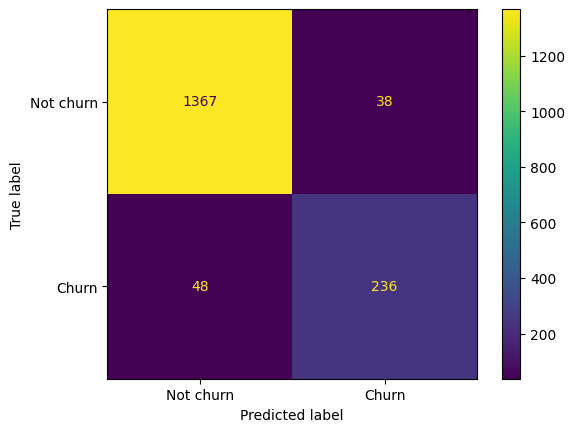

Recall da validação (%):  83.09859154929578
Acurácia da validação (%):  94.90822972172883
SCORE do modelo (%):  89.28397099362633


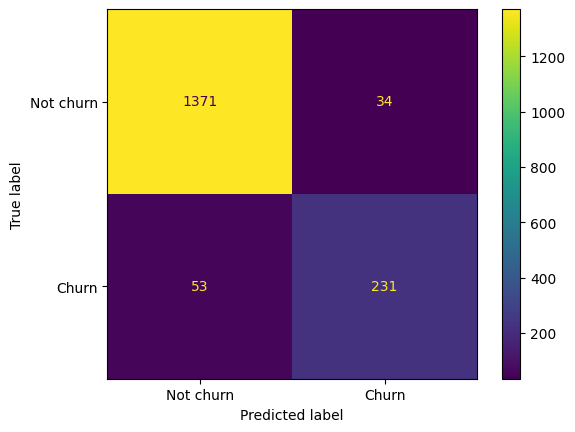

Recall da validação (%):  81.33802816901408
Acurácia da validação (%):  94.84902309058614
SCORE do modelo (%):  89.28397099362633


In [65]:
for thr in thresholds:

  best_criterion = 'gini'
  best_min_samp_split = 2

  train_test(best_criterion, best_min_samp_split, thr, x_train_smt, y_train_smt, x_test_smt, y_test)

Observa-se que o melhor valor de Recall obtido foi com um threshould de 0.4, apresentando um score de validação de modelo equivalente aos demais e uma satisfatória acuracidade.

**IMPLEMENTANDO O APRENDIZADO DE MÁQUINA (BALANCEAMENTO NEAR MISS)**


*   Seleção de hiperparâmetros do modelo preditivo:



In [66]:
list_ReturnRecall_nm = []
list_ReturnAccuracy_nm = []
list_scoresm_nm = []

list_order_criterion = []
list_order_min_samples_split = []

for k in criterion:

  for l in min_samples_split:

    list_order_criterion.append(k)
    list_order_min_samples_split.append(l)

    train_test_hp(k, l, list_scoresm_nm, list_ReturnRecall_nm, list_ReturnAccuracy_nm, x_train_nm, y_train_nm, x_test_nm, y_test)

Recall e Acurácia (RF) com a validação (%): 90.14084507042254 e 50.97690941385436. Scores do modelo gini (MSP = 2): [0.87573964 0.89349112 0.90532544 0.89053254 0.89910979]
Recall e Acurácia (RF) com a validação (%): 89.43661971830986 e 48.84547069271758. Scores do modelo gini (MSP = 3): [0.86982249 0.89053254 0.90828402 0.88461538 0.90207715]
Recall e Acurácia (RF) com a validação (%): 84.85915492957746 e 47.542924807578444. Scores do modelo gini (MSP = 4): [0.86982249 0.88757396 0.8964497  0.87869822 0.90207715]
Recall e Acurácia (RF) com a validação (%): 80.98591549295774 e 46.59561870929544. Scores do modelo gini (MSP = 5): [0.87278107 0.87869822 0.8964497  0.86686391 0.89910979]
Recall e Acurácia (RF) com a validação (%): 79.92957746478874 e 47.01006512729426. Scores do modelo gini (MSP = 6): [0.86982249 0.88461538 0.90236686 0.85502959 0.90504451]
Recall e Acurácia (RF) com a validação (%): 89.43661971830986 e 49.49674363528715. Scores do modelo entropy (MSP = 2): [0.87278107 0.8



*   Recall, Acurácia e Score da validação cruzada do modelo para cada hiperparâmetro estudado:


In [67]:
list_scoresm_average_nm = []
list_scoresm_std_nm = []

for u in list_scoresm_nm:

  average = st.mean(u)
  std = st.stdev(u)

  list_scoresm_average_nm.append(average*100)
  list_scoresm_std_nm.append(std*100)

data_df = {'MSP': list_order_min_samples_split, 'Recall': list_ReturnRecall_nm, 'Accuracy': list_ReturnAccuracy_nm, 'MEAN SCORE': list_scoresm_average_nm, 'STD SCORE': list_scoresm_std_nm}

df_criterions_nm = pd.DataFrame (data_df, index = list_order_criterion, columns = ['MSP', 'Recall', 'Accuracy', 'MEAN SCORE', 'STD SCORE']).sort_values('Recall', ascending=False)
df_criterions_nm

,MSP,Recall,Accuracy,MEAN SCORE,STD SCORE
gini,2,90.140845,50.976909,89.283971,1.110593
gini,3,89.436620,48.845471,89.106632,1.509046
entropy,2,89.436620,49.496744,89.343318,1.250154
log_loss,2,89.436620,49.496744,89.343318,1.250154
entropy,3,88.380282,48.431024,89.402665,1.419545
log_loss,3,88.380282,48.431024,89.402665,1.419545
gini,4,84.859155,47.542925,88.692431,1.304708
entropy,4,84.507042,46.714032,88.929117,1.186626
log_loss,4,84.507042,46.714032,88.929117,1.186626
entropy,5,83.098592,46.773239,88.455744,1.362494


Observa-se, na tabela acima, que o critério "gini" com valor de min_samples_split igual a 2 obteve os melhores indicadores de recall, acuracidade e desvio-padrão, apesar do baixo valor desta acuracidade neste e nos demais dados. Sendo assim, este será utilizado para o posterior treino e teste do modelo sob diferentes thresholds para o balanceamento Near Miss.



*   Treino e Predição:



Para a predição, foram adotados 3 valores de threshold e avaliado qual o melhor desempenho dentre eles.

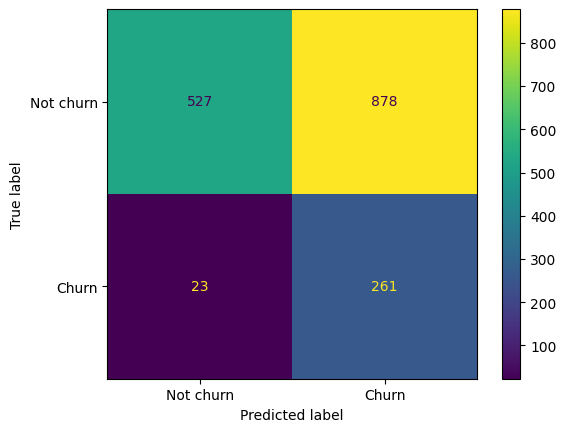

Recall da validação (%):  91.90140845070422
Acurácia da validação (%):  46.65482534043813
SCORE do modelo (%):  89.28397099362633


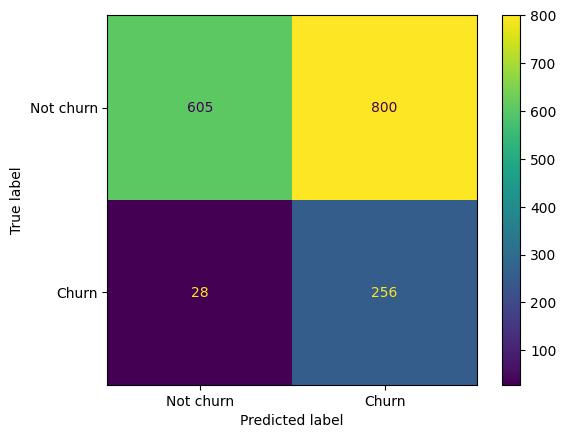

Recall da validação (%):  90.14084507042254
Acurácia da validação (%):  50.97690941385436
SCORE do modelo (%):  89.28397099362633


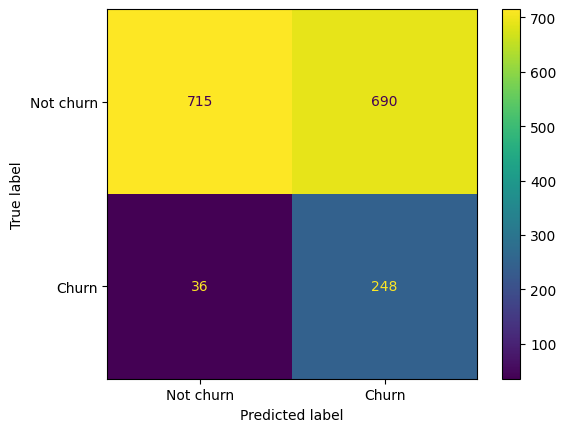

Recall da validação (%):  87.32394366197182
Acurácia da validação (%):  57.01598579040853
SCORE do modelo (%):  89.28397099362633


In [68]:
for thresh in thresholds:

  best_criterion = 'gini'
  best_min_samp_split = 2

  train_test(best_criterion, best_min_samp_split, thresh, x_train_nm, y_train_nm, x_test_nm, y_test)

Diferentemente do método de balanceamento Smote, foram obtidas baixas acuracidades para o modelo Near Miss, apesar dos valores de Recall e Score das validações cruzadas serem satisfatórios. Tal fato pode ser justificado pela significativa redução do volume de dados após esse tipo de balanceamento, o qual não acarretou em uma aprendizagem de máquina eficiente.

**QUAL O MELHOR BALANCEAMENTO?**

Tendo em vista os fatos mencionados, é evidente que o método de balanceamento Smote com critério 'gini', min_samples_split=2 e threshold de 0.4 foi o mais bem avaliado nesse estudo.

**CURVA DE APRENDIZAGEM**

A avaliação das curvas de aprendizagem é de fundamental importância para se identificar a relação entre a quantidade de dados de treino e a eficiência do aprendizado de máquina, sendo crucial no universo da análise de dados. Primeiramente, insere-se o modelo de aprendizado de máquina a ser utilizado:

In [69]:
classif = RandomForestClassifier(n_estimators=100, criterion = 'entropy', min_samples_split = 2,  random_state=42)

In [70]:
score_model_curve = cross_val_score(classif, x_best, y, cv=5, scoring='recall')
score_model_curve = st.mean(score_model_curve)

In [71]:
print("SCORE do modelo da curva de aprendizado (%): ", (score_model_curve*100))

SCORE do modelo da curva de aprendizado (%):  98.73350041771094


Observa-se um score satisfatório para a validação cruzada do modelo.

Em seguida, a curva de aprendizado é implementada da seguinte forma:

In [72]:
train_sizes_abs, train_scores, test_scores = learning_curve(classif, x_best, y, train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99],
                                                            scoring = 'recall', cv=5)

In [73]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

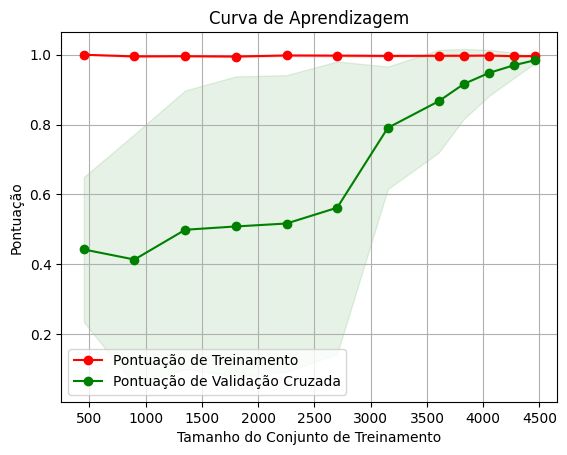

In [74]:
plt.figure()
plt.title("Curva de Aprendizagem")
plt.xlabel("Tamanho do Conjunto de Treinamento")
plt.ylabel("Pontuação")
plt.grid()

plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r",
         label="Pontuação de Treinamento")
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g",
         label="Pontuação de Validação Cruzada")

plt.legend(loc="best")
plt.show()

Observa-se que a pontuação da curva de aprendizagem tendeu a uma estabilização com o aumento do tamanho do conjunto de treinamento (Sobretudo no intervalo de tamanho de conjunto de dados entre 4000 e 4500), o que expressa que a inclusão de novos dados de treinamento provavelmente não trará melhorias significativas ao aprendizado de máquina.